Si reviso `rmbsinbcn` noto que hay puntos que en realidad están dentro del municipio de Barcelona. Por tanto, lo que haré será:
1. Unir `rmbsinbcn` con `bcn`.
2. Eliminar duplicados de la base resultante.
3. Considerar como `bcn` sólo a los puntos que están dentro del municipio (basándome en el [shapefile](https://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=CAANE)), lo que me dará el archivo `a-mun_bcn-marzo24.xlsx`.
4. Obtener una base para la RMB que sea `a-rmb-marzo24.xlsx`.

Además, luego he visto la oportunidad de obtener una base de datos para el Área Metropolitana de Barcelona (AMB), conformada por 36 municipios.

Así, finalmente tendré cuatro bases de datos: `a-prov_mad-marzo24.xlsx` (para toda la provincia), `a-amb_marzo24.xlsx`, `a-mun_bcn-marzo24.xlsx` (sólo el municipio) y `a-rmb-marzo24.xlsx`.

# Revisión inicial

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Leer el DataFrame con las coordenadas
rmbsinbcn = pd.read_excel('data/primera_ronda/pre-procesado/a-rmb-sin_bcn-marzo24-1.xlsx')
bcn=pd.read_excel('data/primera_ronda/pre-procesado/a-mun_bcn-marzo24-1.xlsx')

#### RMB SIN BCN
# Convertir el DataFrame a un GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(rmbsinbcn['Lon_X'], rmbsinbcn['Lat_Y'])]
crs = 'epsg:4326'  # Definir sistema de coordenadas WGS84
gdf_puntos = gpd.GeoDataFrame(rmbsinbcn, crs=crs, geometry=geometry)

# Convertir el GeoDataFrame a EPSG:32631
gdf_puntos = gdf_puntos.to_crs(epsg=32631)

#### BCN
# Convertir el DataFrame a un GeoDataFrame
geometry2 = [Point(lon, lat) for lon, lat in zip(bcn['Lon_X'], bcn['Lat_Y'])]
gdf_puntos2 = gpd.GeoDataFrame(bcn, crs=crs, geometry=geometry2)

# Convertir el GeoDataFrame a EPSG:32631
gdf_puntos2 = gdf_puntos2.to_crs(epsg=32631)

#### MUNICIPIOS
gdf_municipios = gpd.read_file('G:/Mi unidad/Datos/españa/vectores/MUNICIPOS-ESPAÑA-31N.gpkg')

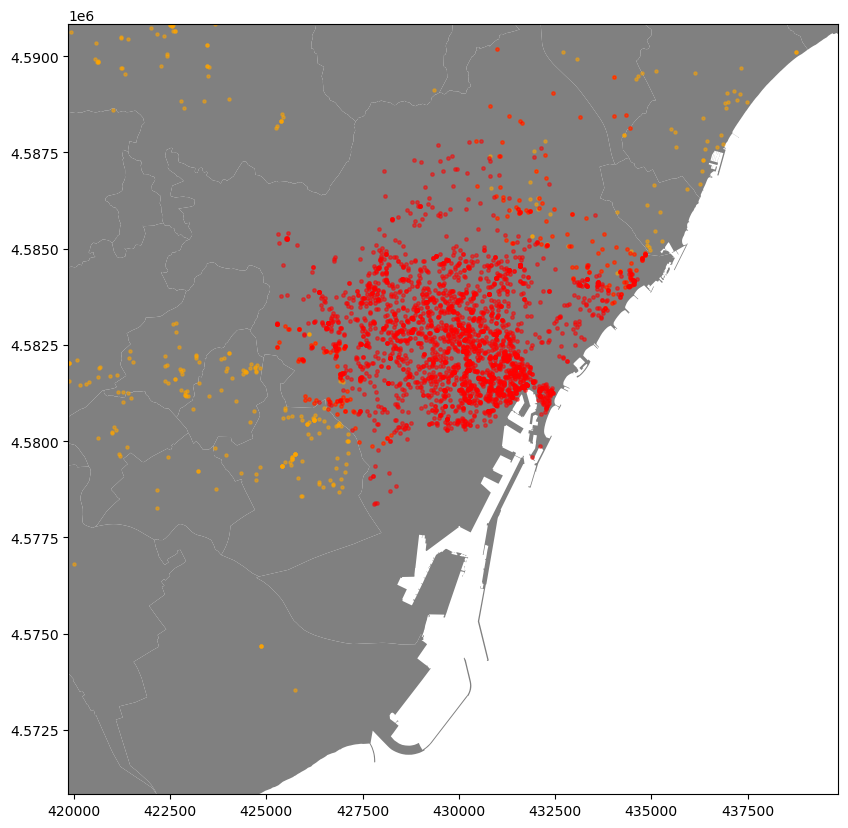

In [3]:
# Calcular el centro de los puntos
center_point = gdf_puntos2.geometry.unary_union.centroid

# Visualizar los datos centrados en los puntos
fig, ax = plt.subplots(figsize=(10, 10))
gdf_municipios.plot(ax=ax, color='gray')
gdf_puntos.plot(ax=ax, color='orange', markersize=5, alpha=0.5) ##Estos vienen de 'rmbsinbcn'
gdf_puntos2.plot(ax=ax, color='red', markersize=6, alpha=0.5) ##Estos vienen de 'bcn'
ax.set_xlim([center_point.x - 10000, center_point.x + 10000])  # Ajustar límites x para centrar en puntos
ax.set_ylim([center_point.y - 10000, center_point.y + 10000])  # Ajustar límites y para centrar en puntos
plt.show()

# 1. Unión de `bcn` con `rmbsinbcn`

In [4]:
# Concatenar los DataFrames uno debajo del otro
df = pd.concat([rmbsinbcn, bcn], axis=0)
len(df)

4308

# 2. Reviso duplicados

In [5]:
columns_to_keep = ['codigo_inmueble', 'Lon_X', 'Lat_Y']

# Crear una lista de columnas excluyendo las columnas que deseas mantener
columns_to_check_duplication = [col for col in df.columns if col not in columns_to_keep]

# Si quieres modificar directamente el DataFrame original, puedes hacer:
df.drop_duplicates(subset=columns_to_check_duplication, keep='first', inplace=True)

# Verificar el DataFrame resultante
len(df)

4308

Convierto el df a una versión georreferenciada.

In [6]:
# Convertir el DataFrame a un GeoDataFrame
geometry3 = [Point(lon, lat) for lon, lat in zip(df['Lon_X'], df['Lat_Y'])]
crs = 'epsg:4326'  # Definir sistema de coordenadas WGS84
gdf_puntos3 = gpd.GeoDataFrame(df, crs=crs, geometry=geometry3)

# Convertir el GeoDataFrame a EPSG:25831
gdf_puntos3 = gdf_puntos3.to_crs(epsg=32631)

# 3. Nueva versión de `bcn`

In [7]:
gdf_municipios.head(1)

,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
0,ES.IGN.BDDAE.34010404001,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34010404001,Abla,ES6,ES61,ES611,"MULTIPOLYGON (((-14292.138 4120932.645, -14246..."


In [8]:
gdf_filtrado = gdf_municipios[gdf_municipios['NAMEUNIT'] == 'Barcelona']

In [9]:
# Realizar una unión espacial entre los dos GeoDataFrames
nuevo_bcn = gpd.sjoin(gdf_puntos3, gdf_filtrado[['geometry']], how='inner', predicate='intersects')

In [10]:
nuevo_bcn.head()

,Title,Link,precio_euros,codigo_inmueble,Description,last_mod,dummy_indice,indice_alquiler,area,n_rooms,...,multifam,atico,duplex,estudio,loft,piso,triplex,temporal,geometry,index_right
78,Alquiler Piso Carrer de sabino arana. Oportun...,https://www.habitaclia.com/alquiler-piso-oport...,1900,Anuncio: 26177004398072,OPORTUNIDAD PISO EN ZONA PRIVILEGIADAEdificio ...,07/03/2024,0,0.0,125,4,...,1,0,0,0,0,1,0.0,0,POINT (426834.500 4581949.040),5116
79,Alquiler Piso en Sant Ramon - Maternitat. Pi...,https://www.habitaclia.com/alquiler-piso-en_le...,1590,Anuncio: 5883004303283,"Piso semiamueblado en Les Corts, a un paso de...",21/03/2024,0,0.0,98,4,...,1,0,0,0,0,1,0.0,0,POINT (425990.536 4581058.733),5116
80,Alquiler Piso Avinguda de madrid. Piso de 4 h...,https://www.habitaclia.com/alquiler-piso-de_4_...,1800,Anuncio: 37701000000071,Apartamento en alquiler por un máximo de 11 me...,06/03/2024,0,0.0,90,4,...,1,0,0,0,0,1,0.0,1,POINT (426903.562 4581059.638),5116
81,Alquiler Piso Carrer de mejía lequerica. Piso...,https://www.habitaclia.com/alquiler-piso-de_10...,2200,Anuncio: 21241000012240,REF. 001625RPRECIO DE ALQUILER DE CORTA ESTANC...,07/02/2024,0,0.0,107,4,...,0,0,0,0,0,0,0.0,1,POINT (426918.324 4581739.999),5116
82,Alquiler Piso en Avinguda de madrid 27. ¡ref...,https://www.habitaclia.com/alquiler-piso-refor...,1150,Anuncio: 12792003591115,Av. Madrid - Regent de Mendieta - ArizalaPreci...,19/03/2024,0,0.0,50,2,...,1,0,0,0,0,1,0.0,0,POINT (426777.485 4580960.146),5116


In [11]:
len(nuevo_bcn)

3109

Creo un ID con base en el índice.

In [12]:
nuevo_bcn.reset_index(drop=True, inplace=True)
nuevo_bcn.index = nuevo_bcn.index + 1
nuevo_bcn.insert(0, 'ID', nuevo_bcn.index)

# 4. Obtengo la base de datos para el RMB

Creo un ID con base en el índice.

In [13]:
df.reset_index(drop=True, inplace=True)
df.index = df.index + 1
df.insert(0, 'ID', df.index)

# 5. Obtengo la base de datos para la AMB

In [14]:
# Leer el archivo geopackage de municipios
gdf_amb = gpd.read_file('G:/Mi unidad/Datos/españa/vectores/MUNICIPIOS-AMB-31N.gpkg')
gdf_amb = gdf_amb.to_crs(epsg=32631) #porque estaba mal seteado

# Realizar una unión espacial entre los dos GeoDataFrames
df_amb = gpd.sjoin(gdf_puntos3, gdf_amb[['geometry']], how='inner', predicate='intersects')

df_amb.head()

,Title,Link,precio_euros,codigo_inmueble,Description,last_mod,dummy_indice,indice_alquiler,area,n_rooms,...,multifam,atico,duplex,estudio,loft,piso,triplex,temporal,geometry,index_right
0,Alquiler Piso en Sant Josep. Obra nueva en l...,https://www.habitaclia.com/alquiler-piso-obra_...,1250,Anuncio: 5020004000934,Sin penalización por desistimiento después de ...,22/03/2024,0,0.0,56,2,...,0,0,0,0,0,0,0.0,0,POINT (425730.368 4579672.293),10
1,Alquiler Piso en Sant Josep. Obra nueva en l...,https://www.habitaclia.com/alquiler-piso-obra_...,1235,Anuncio: 5020004000316,Sin penalización por desistimiento después de ...,22/03/2024,0,0.0,56,2,...,0,0,0,0,0,0,0.0,0,POINT (425730.368 4579672.293),10
2,Alquiler Estudio en Collblanc,https://www.habitaclia.com/alquiler-estudio-co...,770,Anuncio: 48377000000745,RESERVAS E INQUIETUDESPara obtener información...,20/03/2024,0,0.0,25,0,...,1,0,0,1,0,0,0.0,0,POINT (426094.064 4580503.737),10
3,Alquiler Piso Carrer del montseny,https://www.habitaclia.com/alquiler-piso-la_to...,1180,Anuncio: 29091000000788,DISPONIBLE DESDE EL 15 DE MAYO DE 2024========...,15/03/2024,1,25.0,49,2,...,1,0,0,0,0,1,0.0,0,POINT (426354.115 4580200.055),10
4,Alquiler Piso en Sant Josep. Obra nueva en l...,https://www.habitaclia.com/alquiler-piso-obra_...,1255,Anuncio: 5020003999533,Incluido parquin y trastero en la renta.Sin pe...,22/03/2024,0,0.0,56,2,...,0,0,0,0,0,0,0.0,0,POINT (425730.368 4579672.293),10


In [15]:
len(df_amb)

3631

Creo un ID con base en el índice.

In [16]:
df_amb.reset_index(drop=True, inplace=True)
df_amb.index = df_amb.index + 1
df_amb.insert(0, 'ID', df_amb.index)

Para estar seguro de que las escalas son correctas, reviso la cantidad de datos para cada unidad de análisis.

In [17]:
print("Datos para el Municipio de Barcelona:",len(nuevo_bcn))
print("Datos para el AMB:",len(df_amb))
print("Datos para el RMB:",len(df))

Datos para el Municipio de Barcelona: 3109
Datos para el AMB: 3631
Datos para el RMB: 4308


# 7. Revisión de duplicados

Por si las dudas, ahora que se han fusionado áreas, vuelvo a revisar filas con la descripción vacía o duplicada.

In [18]:
#nuevo_bcn.dropna(subset=['Description'], inplace=True)
#nuevo_bcn.drop_duplicates(subset=['Description'], keep='first', inplace=True)

#df_amb.dropna(subset=['Description'], inplace=True)
#df_amb.drop_duplicates(subset=['Description'], keep='first', inplace=True)

#df.dropna(subset=['Description'], inplace=True)
#df.drop_duplicates(subset=['Description'], keep='first', inplace=True)

In [19]:
#print("Datos para el Municipio de Barcelona:",len(nuevo_bcn))
#print("Datos para el AMB:",len(df_amb))
#print("Datos para el RMB:",len(df))

# 7. Exporto

In [20]:
nuevo_bcn.drop(['geometry','index_right'],axis=1).to_excel('data/primera_ronda/a-mun_bcn-marzo24.xlsx',index=False)

In [21]:
df_amb.drop(['geometry','index_right'],axis=1).to_excel('data/primera_ronda/a-amb-marzo24.xlsx',index=False)

In [22]:
df.to_excel('data/primera_ronda/a-rmb-marzo24.xlsx',index=False)